
KNN Accuracy (depression): 0.7653
                              precision    recall  f1-score   support

             Mild Depression       0.69      0.92      0.79       110
          Minimal Depression       0.65      0.50      0.57        26
         Moderate Depression       0.75      0.53      0.62       111
Moderately Severe Depression       0.74      0.79      0.76       113
               No Depression       0.69      0.69      0.69        13
           Severe Depression       0.92      0.87      0.90       134

                    accuracy                           0.77       507
                   macro avg       0.74      0.72      0.72       507
                weighted avg       0.77      0.77      0.76       507


SVC Accuracy (depression): 1.0000
                              precision    recall  f1-score   support

             Mild Depression       1.00      1.00      1.00       110
          Minimal Depression       1.00      1.00      1.00        26
         Moderat

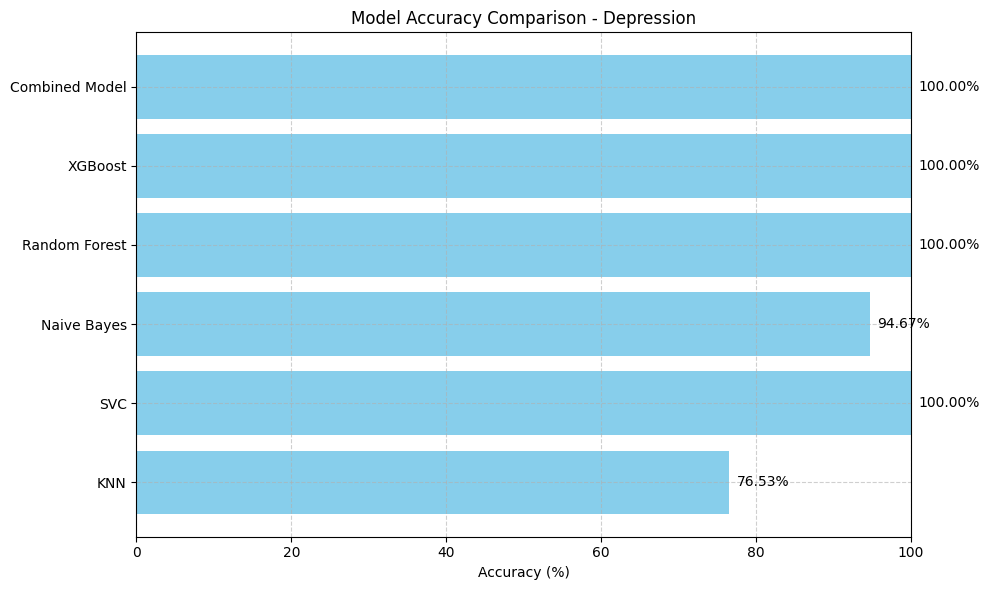


KNN Accuracy (anxiety): 0.8935
                  precision    recall  f1-score   support

    Mild Anxiety       0.82      0.98      0.90       126
 Minimal Anxiety       1.00      0.72      0.84        40
Moderate Anxiety       0.86      0.85      0.86       150
  Severe Anxiety       0.96      0.91      0.93       191

        accuracy                           0.89       507
       macro avg       0.91      0.87      0.88       507
    weighted avg       0.90      0.89      0.89       507


SVC Accuracy (anxiety): 1.0000
                  precision    recall  f1-score   support

    Mild Anxiety       1.00      1.00      1.00       126
 Minimal Anxiety       1.00      1.00      1.00        40
Moderate Anxiety       1.00      1.00      1.00       150
  Severe Anxiety       1.00      1.00      1.00       191

        accuracy                           1.00       507
       macro avg       1.00      1.00      1.00       507
    weighted avg       1.00      1.00      1.00       507


N

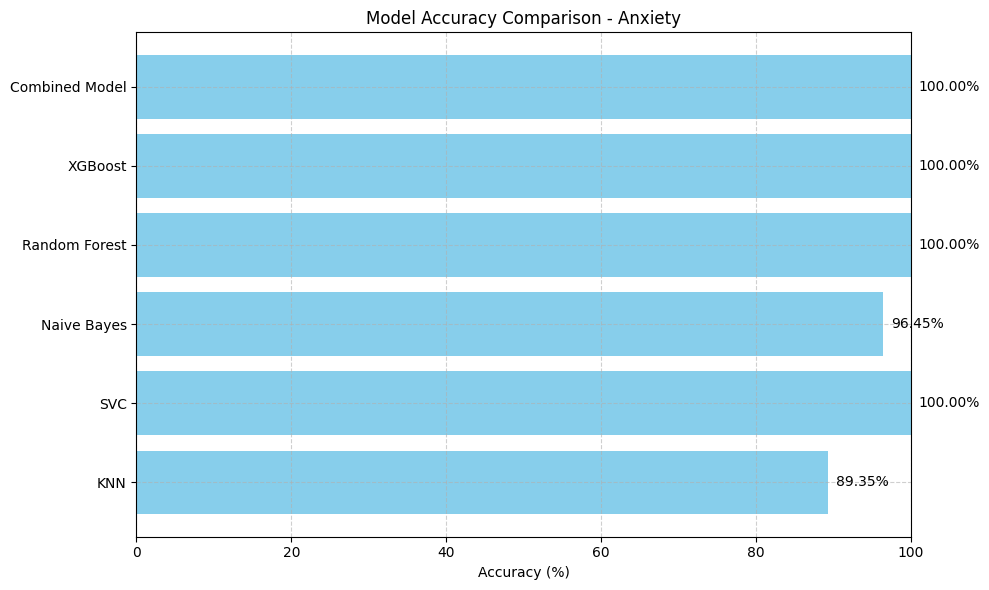


KNN Accuracy (stress): 0.9349
                       precision    recall  f1-score   support

High Perceived Stress       0.96      0.92      0.94       144
           Low Stress       1.00      0.38      0.56        26
      Moderate Stress       0.92      0.99      0.95       337

             accuracy                           0.93       507
            macro avg       0.96      0.76      0.82       507
         weighted avg       0.94      0.93      0.93       507


SVC Accuracy (stress): 0.9961
                       precision    recall  f1-score   support

High Perceived Stress       1.00      1.00      1.00       144
           Low Stress       1.00      0.92      0.96        26
      Moderate Stress       0.99      1.00      1.00       337

             accuracy                           1.00       507
            macro avg       1.00      0.97      0.99       507
         weighted avg       1.00      1.00      1.00       507


Naive Bayes Accuracy (stress): 0.9310
           

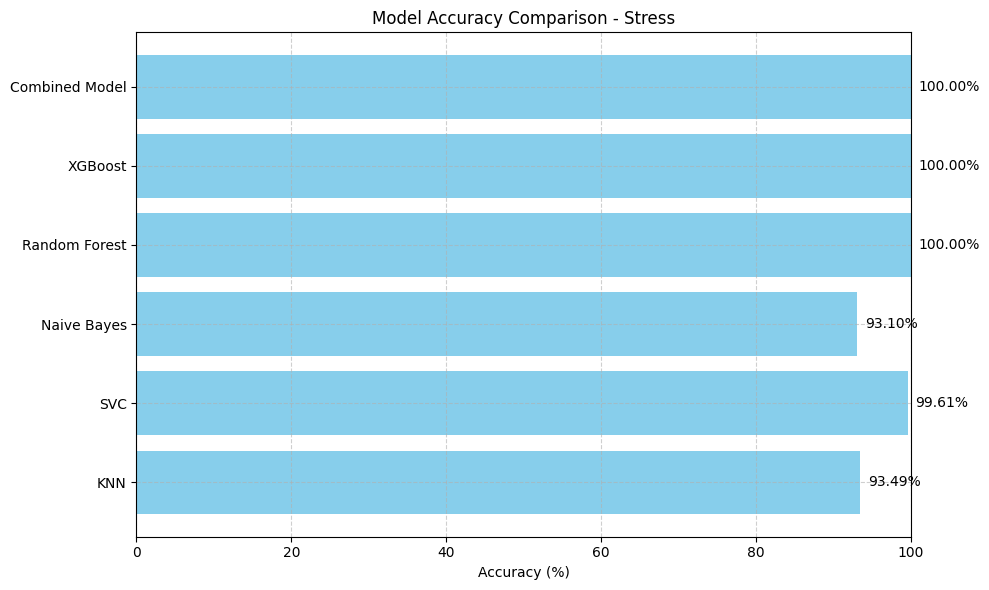

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from collections import Counter
import joblib
import warnings
warnings.filterwarnings('ignore')

def train_and_save_best_model(csv_path, target_col, model_name_prefix):
    # Load dataset
    df = pd.read_csv(csv_path)
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Encode categorical features
    le_features = LabelEncoder()
    for col in X.select_dtypes(include='object').columns:
        X[col] = le_features.fit_transform(X[col])

    # Encode labels
    le_target = LabelEncoder()
    y_encoded = le_target.fit_transform(y)

    # Standardize features
    X = StandardScaler().fit_transform(X)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42)

    # Define models
    models = {
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'SVC': SVC(kernel='linear'),
        'Naive Bayes': GaussianNB(),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    }

    accuracies = {}
    predictions = {}

    # Train and evaluate each model
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies[name] = acc
        predictions[name] = y_pred

        print(f"\n{name} Accuracy ({model_name_prefix}): {acc:.4f}")
        print(classification_report(y_test, y_pred, target_names=le_target.classes_))

    # Combine top 3 models with majority vote
    top_models = sorted(accuracies.items(), key=lambda x: x[1], reverse=True)[:3]
    final_preds = []
    for i in range(len(X_test)):
        votes = [predictions[m[0]][i] for m in top_models]
        final_preds.append(Counter(votes).most_common(1)[0][0])

    combined_acc = accuracy_score(y_test, final_preds)
    accuracies['Combined Model'] = combined_acc

    print(f"\nCombined Voting Accuracy ({model_name_prefix}): {combined_acc:.4f}")
    print(classification_report(y_test, final_preds, target_names=le_target.classes_))

    # Save best individual model
    best_model_name = max(accuracies, key=accuracies.get)
    if best_model_name == "Combined Model":
        best_model_name = top_models[0][0]  # Pick top individual model if combined was best

    joblib.dump(models[best_model_name], f'{model_name_prefix}best_model{best_model_name}.pkl')
    joblib.dump(le_target, f'{model_name_prefix}_label_encoder.pkl')
    print(f"Saved: {model_name_prefix}best_model{best_model_name}.pkl and {model_name_prefix}_label_encoder.pkl")

    # Plotting accuracies
    plt.figure(figsize=(10, 6))
    plt.barh(list(accuracies.keys()), [v * 100 for v in accuracies.values()], color='skyblue')
    plt.xlabel('Accuracy (%)')
    plt.title(f'Model Accuracy Comparison - {model_name_prefix.capitalize()}')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(0, 100)
    for i, v in enumerate(accuracies.values()):
        plt.text(v * 100 + 1, i, f"{v*100:.2f}%", va='center')
    plt.tight_layout()
    plt.show()

# Run for each dataset
train_and_save_best_model('/content/Depression.csv', 'Depression Label', 'depression')
train_and_save_best_model('/content/Anxiety.csv', 'Anxiety Label', 'anxiety')
train_and_save_best_model('/content/Stress.csv', 'Stress Label', 'stress')

In [ ]:
!pip install streamlit pyngrok xgboost opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.5 MB/s eta 0:00:00


In [ ]:
!pip install streamlit pyngrok pillow

In [ ]:
!pip install gTTS

In [ ]:
!pip install SpeechRecognition

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 31.4 MB/s eta 0:00:00


In [ ]:
import streamlit as st

st.markdown("""
    <h4>🎤 Record Your Voice:</h4>
    <p>Use the audio recorder below to speak your thoughts.</p>
    <audio controls></audio>
    <script>
    const audio = document.querySelector("audio");
    if (navigator.mediaDevices.getUserMedia) {
        navigator.mediaDevices.getUserMedia({ audio: true })
        .then(function(stream) {
            const mediaRecorder = new MediaRecorder(stream);
            let chunks = [];
            mediaRecorder.start();
            setTimeout(() => {
                mediaRecorder.stop();
            }, 5000);  // 5 seconds

            mediaRecorder.ondataavailable = function(e) {
                chunks.push(e.data);
            };

            mediaRecorder.onstop = function() {
                const blob = new Blob(chunks, { type: 'audio/wav' });
                audio.src = URL.createObjectURL(blob);
            };
        });
    }
    </script>
""", unsafe_allow_html=True)

2025-05-10 05:48:57.976 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-10 05:48:58.310 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-05-10 05:48:58.313 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [ ]:


!pip install pyttsx3

In [ ]:
pip install secure-smtplib


In [ ]:
pip install fpdf


  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=585f70fe5165940e46d2685fc1fb66765152158fa1905a1a18df83b765e0cbd3
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf


In [ ]:
pip install SpeechRecognition pyaudio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pyaudio (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pyaudio
Failed to build pyaudio
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pyaudio)


In [ ]:
%%writefile mindwell_premium.py
import streamlit as st
import random
import time
from gtts import gTTS
import tempfile
import base64
import os

# ========== PAGE CONFIG ==========
st.set_page_config(
    page_title="MindWell Pro",
    page_icon="🧠",
    layout="wide",
    initial_sidebar_state="expanded"
)

# ========== CONSTANTS ==========
PRIMARY_COLOR = "#6C63FF"
SECONDARY_COLOR = "#4D44DB"
ACCENT_COLOR = "#FF6584"
DARK_BG = "#0F0E17"
CARD_BG = "#1E1D2B"
LIGHT_TEXT = "#FFFFFE"
SUCCESS_COLOR = "#2ECC71"
WARNING_COLOR = "#F39C12"
DANGER_COLOR = "#E74C3C"

questions = {
    'depression': [
        "Little interest or pleasure in doing things",
        "Feeling down, depressed, or hopeless",
        "Trouble falling or staying asleep, or sleeping too much",
        "Feeling tired or having little energy",
        "Poor appetite or overeating",
        "Feeling bad about yourself - or that you are a failure",
        "Trouble concentrating on things",
        "Moving or speaking so slowly that others could notice",
        "Thoughts that you'd be better off dead, or of hurting yourself"
    ],
    'anxiety': [
        "Feeling nervous, anxious, or on edge",
        "Not being able to stop or control worrying",
        "Worrying too much about different things",
        "Trouble relaxing",
        "Being so restless that it is hard to sit still",
        "Becoming easily annoyed or irritable",
        "Feeling afraid as if something awful might happen"
    ],
    'stress': [
        "Feeling upset due to something happening in your academic affairs",
        "Feeling as if you were unable to control important things",
        "Feeling nervous and stressed because of academic pressure",
        "Feeling unable to cope with mandatory academic activities",
        "Feeling confident about handling university problems",
        "Feeling academic things going your way",
        "Able to control irritations in your university affairs",
        "Feeling your academic performance is on top",
        "Angered because of bad performance or low grades",
        "Feeling academic difficulties piling up too high to overcome"
    ]
}

# ========== GAME FUNCTIONS ==========
def positive_affirmations_game():
    st.subheader("🌟 Positive Affirmations")

    affirmations = [
        "I am worthy of love and respect",
        "I am capable of achieving my goals",
        "I choose to focus on what I can control",
        "I am enough just as I am",
        "I embrace challenges as opportunities to grow",
        "I am proud of my progress, no matter how small",
        "I deserve happiness and inner peace",
        "I am resilient and can handle whatever comes my way"
    ]

    if "current_affirmation" not in st.session_state:
        st.session_state.current_affirmation = random.choice(affirmations)

    st.markdown(f"""
    <div style="background:{SECONDARY_COLOR}; padding:20px; border-radius:10px; text-align:center; margin-bottom:20px">
        <h2 style="color:white">"{st.session_state.current_affirmation}"</h2>
    </div>
    """, unsafe_allow_html=True)

    col1, col2 = st.columns(2)
    with col1:
        if st.button("🔊 Speak Affirmation", use_container_width=True):
            audio_bytes = text_to_speech(st.session_state.current_affirmation)
            autoplay_audio(audio_bytes)

    with col2:
        if st.button("🔄 New Affirmation", use_container_width=True):
            st.session_state.current_affirmation = random.choice(affirmations)
            st.rerun()

    st.markdown("### Practice Saying It Out Loud")
    st.write("Repeat the affirmation 3 times with conviction:")

    if st.button("Start Practice Session", type="primary"):
        practice_container = st.empty()
        for i in range(1, 4):
            practice_container.markdown(f"""
            <div style="background:{PRIMARY_COLOR}; padding:15px; border-radius:8px; text-align:center">
                <h3 style="color:white">Say: "{st.session_state.current_affirmation}"</h3>
                <p style="color:white">Repetition {i}/3</p>
            </div>
            """, unsafe_allow_html=True)
            time.sleep(3)  # Give time to say it out loud

        practice_container.markdown(f"""
        <div style="background:{SUCCESS_COLOR}; padding:15px; border-radius:8px; text-align:center">
            <h3 style="color:white">Great job! ✨</h3>
            <p style="color:white">You've completed your affirmation practice</p>
        </div>
        """, unsafe_allow_html=True)
        st.balloons()

def breathing_game():
    st.subheader("🧘 Guided Breathing Exercise")
    breath_pattern = st.selectbox("Pattern", ["4-7-8 (Calming)", "4-4-4 (Balancing)", "5-5-5 (Energizing)"])

    if breath_pattern == "4-7-8 (Calming)":
        inhale, hold, exhale = 4, 7, 8
    elif breath_pattern == "4-4-4 (Balancing)":
        inhale, hold, exhale = 4, 4, 4
    else:
        inhale, hold, exhale = 5, 5, 5

    if st.button("Start Session"):
        breath_container = st.empty()

        for cycle in range(3):
            breath_container.markdown(f"""
            <div style="background:{SECONDARY_COLOR}; padding:20px; border-radius:10px; text-align:center">
                <h2 style="color:white">Breathe In</h2>
                <p style="color:white">{inhale} seconds</p>
            </div>
            """, unsafe_allow_html=True)
            time.sleep(inhale)

            breath_container.markdown(f"""
            <div style="background:{PRIMARY_COLOR}; padding:20px; border-radius:10px; text-align:center">
                <h2 style="color:white">Hold</h2>
                <p style="color:white">{hold} seconds</p>
            </div>
            """, unsafe_allow_html=True)
            time.sleep(hold)

            breath_container.markdown(f"""
            <div style="background:{ACCENT_COLOR}; padding:20px; border-radius:10px; text-align:center">
                <h2 style="color:white">Breathe Out</h2>
                <p style="color:white">{exhale} seconds</p>
            </div>
            """, unsafe_allow_html=True)
            time.sleep(exhale)

        breath_container.markdown(f"""
        <div style="background:{SUCCESS_COLOR}; padding:20px; border-radius:10px; text-align:center">
            <h2 style="color:white">Session Complete!</h2>
        </div>
        """, unsafe_allow_html=True)
        st.balloons()

def emotion_game():
    st.subheader("😊 Emotion Recognition")
    emoji_dict = {
        "😊": "Happy", "😢": "Sad", "😡": "Angry", "😱": "Afraid",
        "😌": "Relaxed", "😕": "Confused"
    }

    if "current_emotion" not in st.session_state:
        st.session_state.current_emotion = random.choice(list(emoji_dict.items()))

    emoji, correct = st.session_state.current_emotion

    st.write(f"Emoji: {emoji}")
    answer = st.selectbox("What emotion is this?", list(emoji_dict.values()))

    if st.button("Submit"):
        if answer == correct:
            st.success("Correct! 🎉")
        else:
            st.error(f"Oops! It was: {correct}")
        st.session_state.current_emotion = random.choice(list(emoji_dict.items()))
        st.rerun()

def word_puzzle_game():
    st.subheader("🔤 Word Puzzle")
    words = ["RELAX", "CALM", "PEACE", "SERENE", "MINDFUL", "BREATHE"]
    word = random.choice(words)
    scrambled = list(word)
    random.shuffle(scrambled)

    if "puzzle_attempts" not in st.session_state:
        st.session_state.puzzle_attempts = 0
        st.session_state.puzzle_solved = False

    st.write(f"Unscramble this word: {' '.join(scrambled)}")
    guess = st.text_input("Your guess:").upper()

    if st.button("Check Answer"):
        st.session_state.puzzle_attempts += 1
        if guess == word:
            st.session_state.puzzle_solved = True
            st.success(f"Correct! 🎉 Solved in {st.session_state.puzzle_attempts} attempts")
            st.balloons()
        else:
            st.error("Not quite right. Try again!")

    if st.session_state.puzzle_solved and st.button("New Puzzle"):
        st.session_state.puzzle_attempts = 0
        st.session_state.puzzle_solved = False
        st.rerun()

# ========== ASSESSMENT FUNCTIONS ==========
def text_to_speech(text):
    tts = gTTS(text=text, lang='en')
    with tempfile.NamedTemporaryFile(delete=False, suffix=".mp3") as f:
        tts.save(f.name)
        with open(f.name, "rb") as audio_file:
            audio_bytes = audio_file.read()
        os.unlink(f.name)
    return audio_bytes

def autoplay_audio(audio_bytes):
    b64 = base64.b64encode(audio_bytes).decode()
    md = f"""
    <audio controls autoplay>
    <source src="data:audio/mp3;base64,{b64}" type="audio/mp3">
    </audio>
    """
    st.markdown(md, unsafe_allow_html=True)

def question_component(domain, idx):
    options = ["Not at all", "Several days", "More than half", "Nearly every"]
    current_value = st.session_state.responses[domain][idx]

    with st.container():
        col1, col2 = st.columns([0.9, 0.1])
        with col1:
            st.markdown(f"""
            <div style="background:{CARD_BG}; padding:15px; border-radius:8px;
                        border-left:4px solid {PRIMARY_COLOR}; margin-bottom:10px">
                <h4 style="color:{LIGHT_TEXT}">{idx+1}. {questions[domain][idx]}</h4>
            </div>
            """, unsafe_allow_html=True)
        with col2:
            if st.button("🔊", key=f"voice_{domain}_{idx}"):
                audio_bytes = text_to_speech(questions[domain][idx])
                autoplay_audio(audio_bytes)

        selected_option = st.radio(
            f"Select response for question {idx+1}",
            options=options,
            index=current_value if current_value is not None else 0,
            key=f"options_{domain}_{idx}",
            horizontal=True,
            label_visibility="collapsed"
        )

        st.session_state.responses[domain][idx] = options.index(selected_option)

def show_results(depression_score, anxiety_score, stress_score):
    depression_level = ["None", "Mild", "Moderate", "Severe"][min(3, depression_score // 5)]
    anxiety_level = ["None", "Mild", "Moderate", "Severe"][min(3, anxiety_score // 4)]
    stress_level = ["None", "Mild", "Moderate", "Severe"][min(3, stress_score // 6)]

    result_html = f"""
    <div style="background:{CARD_BG}; padding:20px; border-radius:10px; margin:20px 0">
        <h2 style="color:{LIGHT_TEXT}">Assessment Results</h2>
        <div style="display: flex; gap: 16px; margin: 24px 0; flex-wrap: wrap">
            <div style="flex:1; min-width:250px; background:#2A2938; padding:16px; border-radius:8px; border-left:4px solid {PRIMARY_COLOR}">
                <h4 style="color:{LIGHT_TEXT}">Depression</h4>
                <h3 style="color:{PRIMARY_COLOR}">{depression_level}</h3>
                <p style="color:{LIGHT_TEXT}; opacity:0.7">Score: {depression_score}/27</p>
            </div>
            <div style="flex:1; min-width:250px; background:#2A2938; padding:16px; border-radius:8px; border-left:4px solid {ACCENT_COLOR}">
                <h4 style="color:{LIGHT_TEXT}">Anxiety</h4>
                <h3 style="color:{ACCENT_COLOR}">{anxiety_level}</h3>
                <p style="color:{LIGHT_TEXT}; opacity:0.7">Score: {anxiety_score}/21</p>
            </div>
            <div style="flex:1; min-width:250px; background:#2A2938; padding:16px; border-radius:8px; border-left:4px solid {SECONDARY_COLOR}">
                <h4 style="color:{LIGHT_TEXT}">Stress</h4>
                <h3 style="color:{SECONDARY_COLOR}">{stress_level}</h3>
                <p style="color:{LIGHT_TEXT}; opacity:0.7">Score: {stress_score}/30</p>
            </div>
        </div>
    </div>
    """
    st.markdown(result_html, unsafe_allow_html=True)

# ========== MAIN APP ==========
def main():
    # Initialize session state
    if 'responses' not in st.session_state:
        st.session_state.responses = {
            'depression': [None]*len(questions['depression']),
            'anxiety': [None]*len(questions['anxiety']),
            'stress': [None]*len(questions['stress'])
        }

    # CSS Styling
    st.markdown(f"""
    <style>
    .main, .stApp {{
        background-color: {DARK_BG};
        color: {LIGHT_TEXT};
    }}
    .stRadio > div {{
        background: {CARD_BG};
        border-radius: 8px;
        padding: 10px;
    }}
    .stButton > button {{
        background-color: {PRIMARY_COLOR};
        color: white;
        border-radius: 8px;
    }}
    .stButton > button:hover {{
        background-color: {SECONDARY_COLOR};
    }}
    .stTabs [data-baseweb="tab-list"] button [data-testid="stMarkdownContainer"] p {{
        font-size:1rem;
    }}
    </style>
    """, unsafe_allow_html=True)

    # Header
    st.markdown(f"""
    <div style="display:flex; align-items:center; gap:15px; margin-bottom:15px">
        <h1 style="color:{PRIMARY_COLOR}">MindWell Pro</h1>
    </div>
    <p style="color:{LIGHT_TEXT}">Comprehensive Mental Health Assessment</p>
    <hr>
    """, unsafe_allow_html=True)

    # Main Content
    tab1, tab2, tab3 = st.tabs([
        f"💙 Depression ({sum(1 for r in st.session_state.responses['depression'] if r is not None)}/{len(questions['depression'])})",
        f"💛 Anxiety ({sum(1 for r in st.session_state.responses['anxiety'] if r is not None)}/{len(questions['anxiety'])})",
        f"💚 Stress ({sum(1 for r in st.session_state.responses['stress'] if r is not None)}/{len(questions['stress'])})"
    ])

    with tab1:
        st.header("Depression Assessment (PHQ-9)", divider="blue")
        for i in range(len(questions['depression'])):
            question_component('depression', i)

    with tab2:
        st.header("Anxiety Assessment (GAD-7)", divider="blue")
        for i in range(len(questions['anxiety'])):
            question_component('anxiety', i)

    with tab3:
        st.header("Stress Assessment (PSS)", divider="blue")
        for i in range(len(questions['stress'])):
            question_component('stress', i)

    if st.button("📊 Get Results", type="primary", use_container_width=True):
        depression_score = sum(st.session_state.responses['depression']) * 3
        anxiety_score = sum(st.session_state.responses['anxiety']) * 3
        stress_score = sum(st.session_state.responses['stress']) * 3
        show_results(depression_score, anxiety_score, stress_score)

    # Games Section in Sidebar
    st.sidebar.markdown(f"""
    <div style="background:{CARD_BG}; padding:15px; border-radius:10px; margin-bottom:20px">
        <h3>🧠 Wellness Games</h3>
        <p style="color:{LIGHT_TEXT}; opacity:0.8">Relax and train your mind</p>
    </div>
    """, unsafe_allow_html=True)

    game_choice = st.sidebar.selectbox(
        "Choose a Game",
        ["None", "Positive Affirmations", "Breathing Exercise", "Emotion Recognition", "Word Puzzle"]
    )

    if game_choice == "Positive Affirmations":
        positive_affirmations_game()
    elif game_choice == "Breathing Exercise":
        breathing_game()
    elif game_choice == "Emotion Recognition":
        emotion_game()
    elif game_choice == "Word Puzzle":
        word_puzzle_game()

    # Footer
    st.markdown("---")
    st.markdown(f"""
    <div style="text-align:center; color:{LIGHT_TEXT}; opacity:0.7">
        MindWell Pro © 2023 | Mental Health Support
    </div>
    """, unsafe_allow_html=True)

if __name__ == "__main__":
    main()

Writing mindwell_premium.py


In [ ]:
!streamlit run mindwell_premium.py --server.port 8501

In [ ]:
# Run with ngrok
from pyngrok import ngrok

# Set your ngrok authtoken
ngrok.set_auth_token("2wiFCa57AIsopiIHq2ryYgFD9Y5_3qu1DBa1A1udor1hDKkxx")  # Replace with your actual token

# Start ngrok tunnel
public_url = ngrok.connect(8501)
print(f"Public URL: {public_url}")

# Run Streamlit
!streamlit run mindwell_premium.py --server.port 8501 --server.enableCORS false --server.enableXsrfProtection false &

Public URL: NgrokTunnel: "https://5dfe-34-80-156-31.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.80.156.31:8501

